In [1]:
import numpy as np
import pandas as pd

a_lengths = np.array([24, 23.5, 25.5, 22.0, 25.5, 25.5, 24.0, 28.0, 24.5])
c_lengths = np.array([24.0, 23.0, 21.0, 15.5, 17.5, 17.5, 19.0, 17.0, 17.0, 27.0])

a_labels = np.ones(a_lengths.shape[0], dtype=int)
c_labels = np.zeros(c_lengths.shape[0], dtype=int)

lengths = np.concatenate([a_lengths, c_lengths])
labels = np.concatenate([a_labels, c_labels])
df = pd.DataFrame({ 'length': lengths, 'label': labels})

Text(0.5, 1.0, 'Density Plots of Children, Adults and All')

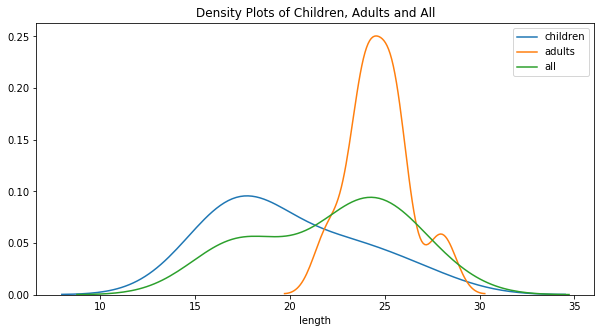

In [2]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 5))

sns.distplot(df[df['label'] == 0]['length'], label='children', hist=False)
sns.distplot(df[df['label'] == 1]['length'], label='adults', hist=False)
sns.distplot(df['length'], label='all', hist=False)
ax.set_title('Density Plots of Children, Adults and All')

In [3]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture

def get_silhouette_score(X, k):
    model = KMeans(k, random_state=37)
    model.fit(X)
    labels = model.predict(X)
    score = silhouette_score(X, labels)
    return score

def get_gmm_score(X, k):
    gmm = GaussianMixture(n_components=k, max_iter=50)
    gmm.fit(X)
    gmm_scores = gmm.score_samples(X)
    score = np.exp(gmm_scores).sum()
    return score

def get_scores(X, k):
    return k, get_silhouette_score(X, k), get_gmm_score(X, k)

X = df['length'].values.reshape(-1, 1)

score_df = pd.DataFrame([get_scores(X, k) for k in range(2, 11, 1)], columns=['k', 'sil', 'gmm'])

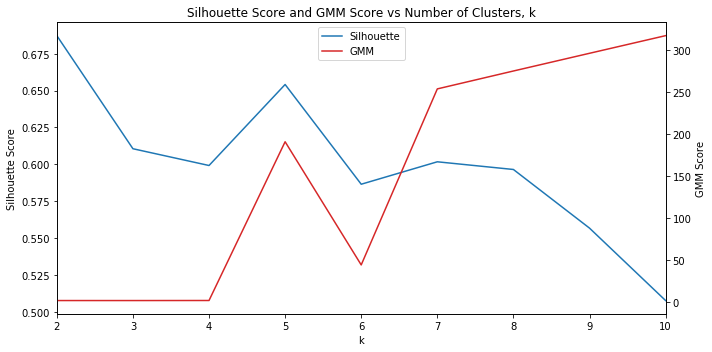

In [4]:
fig, ax1 = plt.subplots(figsize=(10, 5))

k_min = np.min(score_df['k'])
k_max = np.max(score_df['k'])

line1 = ax1.plot(score_df['k'], score_df['sil'], color='tab:blue', label='Silhouette')
ax2 = ax1.twinx()
line2 = ax2.plot(score_df['k'], score_df['gmm'], color='tab:red', label='GMM')

lines = line1 + line2
labels = [l.get_label() for l in lines]

ax1.set_title('Silhouette Score and GMM Score vs Number of Clusters, k')
ax1.legend(lines, labels, loc=9)
ax1.set_xlabel('k')
ax1.set_ylabel('Silhouette Score')
ax1.set_xlim([k_min, k_max])
ax2.set_ylabel('GMM Score')

fig.tight_layout()

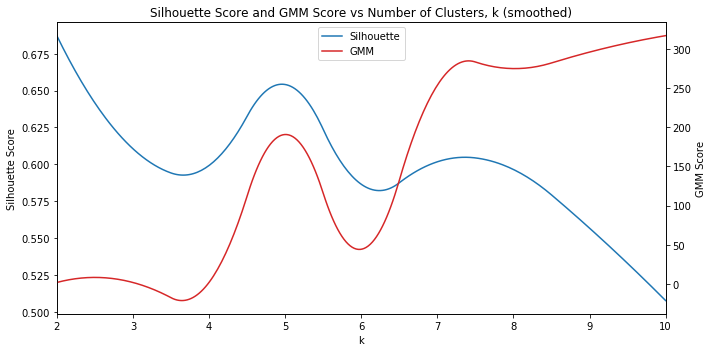

In [5]:
from scipy.interpolate import make_interp_spline, BSpline

fig, ax1 = plt.subplots(figsize=(10, 5))

k_min = np.min(score_df['k'])
k_max = np.max(score_df['k'])
x_new = np.linspace(k_min, k_max, 300)
sil_spline = make_interp_spline(score_df['k'], score_df['sil'], k=2)
gmm_spline = make_interp_spline(score_df['k'], score_df['gmm'], k=2)
sil_smooth = sil_spline(x_new)
gmm_smooth = gmm_spline(x_new)

line1 = ax1.plot(x_new, sil_smooth, color='tab:blue', label='Silhouette')
ax2 = ax1.twinx()
line2 = ax2.plot(x_new, gmm_smooth, color='tab:red', label='GMM')

lines = line1 + line2
labels = [l.get_label() for l in lines]

ax1.set_title('Silhouette Score and GMM Score vs Number of Clusters, k (smoothed)')
ax1.legend(lines, labels, loc=9)
ax1.set_xlabel('k')
ax1.set_ylabel('Silhouette Score')
ax1.set_xlim([k_min, k_max])
ax2.set_ylabel('GMM Score')

fig.tight_layout()

In [6]:
def get_kmeans_labels(X, k):
    model = KMeans(k, random_state=37)
    model.fit(X)
    labels = model.predict(X)
    return labels

prediction_df = df.copy()

best_k = int(score_df.sort_values(['sil'], ascending=False).iloc[0]['k'])
prediction_df['predicted_label'] = get_kmeans_labels(X, best_k)
print('best k = {}'.format(best_k))

best k = 2


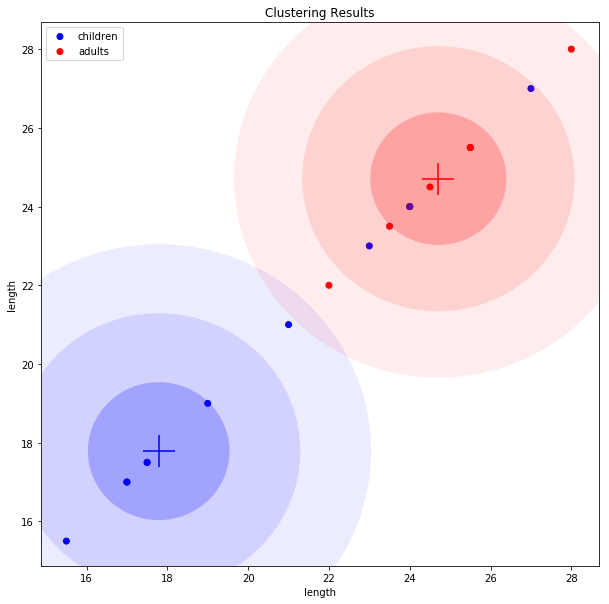

In [7]:
import matplotlib.colors as colors
from matplotlib.patches import Ellipse

fig, ax = plt.subplots(figsize=(10, 10))
colorset = ['blue', 'red']

for cluster, label in zip(range(best_k), ['children', 'adults']):
    cluster_df = prediction_df[prediction_df['predicted_label'] == cluster]
    mu = cluster_df.mean().loc['length']
    cov = cluster_df.var().loc['length']
    cov = np.array([[cov]])
    
    eva, eve = np.linalg.eigh(cov)
    order = eva.argsort()[::-1]
    eva, eve = eva[order], eve[:, order]
    vx, vy = eve[:,0][0], eve[:,0][0]
    theta = np.arctan2(vy, vx)
    color = colors.to_rgba(colorset[cluster])
    
    for cov_factor in range(1, 4):
        size = np.sqrt(eva[0]) * cov_factor * 2
        angle = np.degrees(theta)
        ell = Ellipse(
            xy=(mu, mu), 
            width=size, 
            height=size, 
            angle=angle, 
            linewidth=2)
        ell.set_facecolor((color[0], color[1], color[2], 1.0 / (cov_factor * 4.5)))
        ax.add_artist(ell)
    
    c = [colorset[v] for v in cluster_df['label'].values]
    ax.scatter(mu, mu, marker='+', s=1000, c=colorset[cluster])
    ax.scatter(cluster_df['length'], cluster_df['length'], label=label, c=c, marker='o')
    
ax.set_title('Clustering Results')
ax.set_xlabel('length')
ax.set_ylabel('length')
ax.legend()